In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model  import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
JPM = yf.Ticker('JPM')
JPM = JPM.history(start='2014-12-29',end='2021-12-31')
JPM['Rendimenti'] = JPM['Open'].diff() # aggiungo i valori dei rendimenti
JPM.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Rendimenti
count,1765.000000,1765.000000,1765.000000,1765.000000,1.765000e+03,1765.000000,1765.0,1764.000000
mean,91.342704,92.192813,90.501867,91.342650,1.513972e+07,0.010561,0.0,0.059664
std,32.298304,32.594387,32.015842,32.287111,6.646317e+06,0.087102,0.0,1.599051
min,44.290198,44.985636,41.205581,44.168369,3.324300e+06,0.000000,0.0,-9.997935
25%,57.150766,57.417885,56.913571,57.184654,1.088610e+07,0.000000,0.0,-0.617237
50%,92.367526,93.351821,91.509273,92.404427,1.354240e+07,0.000000,0.0,0.069621
75%,103.703541,104.452397,103.000139,103.663681,1.725090e+07,0.000000,0.0,0.756379
max,168.923474,169.167993,166.801051,168.013870,5.619230e+07,1.000000,0.0,10.401403


In [95]:
print(JPM[JPM['Open']==JPM['Open'].min()])
print(JPM[JPM['Open']==JPM['Open'].max()])

                 Open       High        Low      Close    Volume  Dividends  \
Date                                                                          
2015-02-02  44.290198  45.199884  44.079023  45.053684  20308900        0.0   

            Stock Splits  Rendimenti  
Date                                  
2015-02-02             0   -0.373624  
                  Open        High         Low       Close    Volume  \
Date                                                                   
2021-10-25  168.923474  169.167993  166.742355  167.192276  10159200   

            Dividends  Stock Splits  Rendimenti  
Date                                             
2021-10-25        0.0             0    2.621237  


ANALISI ESPLORATIVA

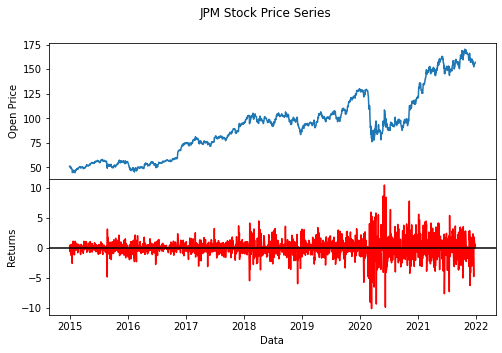

In [3]:
fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle('JPM Stock Price Series')
axs[0].plot(JPM['Open'])
axs[1].plot(JPM['Rendimenti'], color ="red")
axs[1].axhline(y=0.045864, color = "black", linestyle="solid")
axs[1].set_xlabel("Data")
axs[1].set_ylabel("Returns")
axs[0].set_ylabel("Open Price")
for ax in axs.flat:
    ax.label_outer()

# la serie mostra un forte trend, e una volatilità crescente con un cluster abbastanza corposo nell'ultimo periodo.
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\serie.pdf", bbox_inches='tight', format="pdf")

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


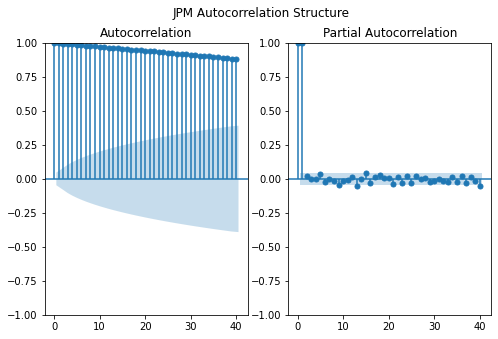

In [4]:
# ACF E PACF della serie; utile anche a capire l'ordine del modello ARIMA
fig, ax = plt.subplots(1, 2, figsize=(8,5))
plot_acf(JPM['Open'], lags=40, ax=ax[0])
plot_pacf(JPM['Open'], lags=40, ax=ax[1])
plt.suptitle("JPM Autocorrelation Structure")
plt.show()
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\cor.pdf", bbox_inches='tight', format="pdf")

In [5]:
#Test ADF per la verifica dell'ipotesi nulla di radice unitaria
adfTest = adfuller(JPM['Open'], autolag = 'AIC')
dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
print('Augmented Dickey-Fuller Test Results:\n')
print(dfResults)
# non si rifiuta l'ipotesi nulla di radice unitaria

Augmented Dickey-Fuller Test Results:

ADF Test Statistic       -0.431580
P-Value                   0.904691
# Lags Used               5.000000
# Observations Used    1759.000000
dtype: float64


MODELLAZIONE ARIMA



In [3]:
# creazione del train e del test set
size = int(len(JPM) * 0.72)
print(size)
dataset_train = JPM[0:size]
training_set = dataset_train.iloc[:, 0:1].values
dataset_test = JPM[size:]
test_set = dataset_test.iloc[:,0:1].values
print(training_set.shape)
print(test_set.shape)

1270
(1270, 1)
(495, 1)


In [4]:
history = [x for x in training_set]
predictions = list()
# walk-forward validation
for t in range(len(test_set)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_set[t]
    history.append(obs)

In [6]:
print(model_fit.summary()) # si rifiuta l'ipotesi nulla di normalità dei residui; il Ljung box è non significativo e quindi il modello filtra la serie
# dalla dipendenza seriale

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1764
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3328.883
Date:                Tue, 19 Jul 2022   AIC                           6661.766
Time:                        11:16:13   BIC                           6672.716
Sample:                             0   HQIC                          6665.812
                               - 1764                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0411      0.014     -2.948      0.003      -0.068      -0.014
sigma2         2.5561      0.041     62.621      0.000       2.476       2.636
Ljung-Box (L1) (Q):                   0.00   Jarque-

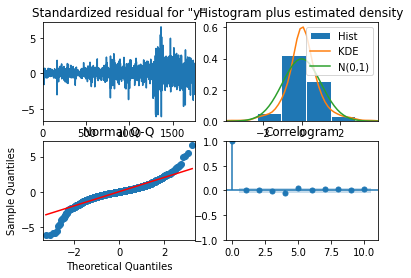

In [11]:
model_fit.plot_diagnostics() # forte asimmetria nella distribuzione dei residui
plt.show()

In [ ]:
print(test_set.shape)
print(np.array(predictions).shape)

(290, 1)
(290, 1)


In [7]:
# valutazione delle previsioni
mse = mean_squared_error(test_set, predictions)
print('Mean Squared Error:\t',mse)

Mean Squared Error:	 6.436606809863413


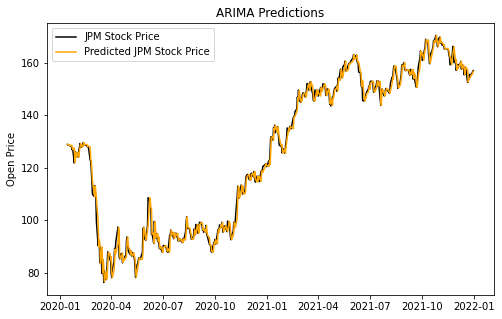

In [7]:
predictions = pd.DataFrame(predictions)
predictions= predictions.set_index(dataset_test.index)
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], color ="black", label = "JPM Stock Price")
plt.plot(predictions, color="orange", label = "Predicted JPM Stock Price")
plt.legend()
plt.ylabel("Open Price")
plt.title("ARIMA Predictions")
plt.show()
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_arima.pdf", bbox_inches='tight', format="pdf")

In [8]:
history = [x for x in training_set]
predictions = list()
# walk-forward validation
for t in range(len(test_set)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_set[t]
    history.append(obs)

In [9]:
print(model_fit.summary()) 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1764
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -3328.616
Date:                Tue, 19 Jul 2022   AIC                           6663.232
Time:                        11:17:37   BIC                           6679.656
Sample:                             0   HQIC                          6669.301
                               - 1764                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0404      0.014     -2.852      0.004      -0.068      -0.013
ar.L2          0.0174      0.014      1.227      0.220      -0.010       0.045
sigma2         2.5554      0.042     61.542      0.0

In [10]:
mse2 = mean_squared_error(test_set, predictions)
print('Mean Squared Error:\t',mse2)

Mean Squared Error:	 6.462958973039296


CONVOLUTIONAL NEURAL NETWORK

In [4]:
mc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = mc.fit_transform(training_set)
print(training_set_scaled.shape)

(1270, 1)


In [33]:
# Costruzione del set di training per la multi-step walk forward validation con finestra temporale di 5 giorni
X_train = []
y_train = []
temp = 5
for i in range(temp, training_set.shape[0], temp):
  X_train.append(training_set_scaled[i-temp:i])
  y_train.append(training_set_scaled[i:i+temp])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(253, 5, 1)
(253, 5, 1)
(253, 5, 1)


In [34]:
# Costruzione del test set
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - temp:].values
inputs = inputs.reshape(-1,1)
inputs = mc.transform(inputs)
X_test = []
for i in range(5, inputs.shape[0], 5):
  X_test.append(inputs[i-temp:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(99, 5, 1)


In [7]:
model_5_CNN = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu', kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu",  kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.Dense(5, activation = "relu",  kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02))
    ]
)
model_5_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 64)             256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 2,501
Trainable params: 2,501
Non-trainable params: 0
______________________________________________________

In [8]:
earlyStop = keras.callbacks.EarlyStopping(patience=2, mode='min')
model_5_CNN.compile(loss=keras.losses.mean_squared_error, optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])
model1_fit=model_5_CNN.fit(X_train, y_train, batch_size=4, epochs=20, validation_split=0.1, callbacks=[earlyStop])

Epoch 1/20
57/57 [==============================] - 1s 5ms/step - loss: 0.0727 - root_mean_squared_error: 0.2697 - val_loss: 0.0391 - val_root_mean_squared_error: 0.1978
Epoch 2/20
57/57 [==============================] - 0s 3ms/step - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0651
Epoch 3/20
57/57 [==============================] - 0s 4ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0337
Epoch 4/20
57/57 [==============================] - 0s 2ms/step - loss: 7.1787e-04 - root_mean_squared_error: 0.0268 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0349
Epoch 5/20
57/57 [==============================] - 0s 3ms/step - loss: 6.8552e-04 - root_mean_squared_error: 0.0262 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0343


In [9]:
predicted_stock_price = model_5_CNN.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price= predicted_stock_price.set_index(dataset_test.index)

Mean Squared Error:	 30.836520026636286
Root Mean Squared Error:	 5.553064021478258


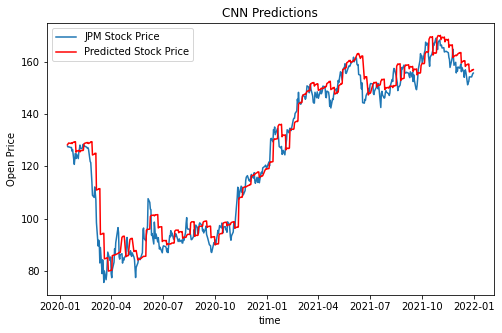

In [11]:
# MSE e rappresentazione delle previsioni
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'].values, predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("CNN Predictions")
plt.legend()
plt.show()
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_cnn1.pdf", bbox_inches='tight', format="pdf")

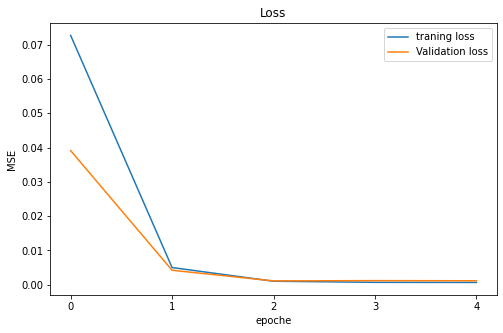

In [12]:
epoche = model1_fit.history['val_loss']
fig = plt.figure(figsize=(8,5))
plt.plot(model1_fit.history['loss'], label="traning loss")
plt.plot(model1_fit.history['val_loss'], label = "Validation loss")
plt.xticks(range(0,len(epoche)))
plt.xlabel("epoche")
plt.ylabel("MSE")
plt.title("Loss")
plt.legend()
plt.show()
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\loss_cnn1.pdf", bbox_inches='tight', format="pdf")

In [14]:
# cambio algoritmo di ottimizzazione:  RMSprop
model_5_CNN_rms = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu', kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu",  kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.Dense(5, activation = "relu",  kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02))
    ]
)
optimizer = keras.optimizers.RMSprop()
model_5_CNN_rms.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer, metrics=[keras.metrics.RootMeanSquaredError()])
model2_fit =model_5_CNN_rms.fit(X_train, y_train, batch_size=4, epochs=20, validation_split=0.1, callbacks=[earlyStop])

Epoch 1/20
57/57 [==============================] - 1s 4ms/step - loss: 0.0371 - root_mean_squared_error: 0.1925 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0741
Epoch 2/20
57/57 [==============================] - 0s 2ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 3/20
57/57 [==============================] - 0s 3ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0417
Epoch 4/20
57/57 [==============================] - 0s 3ms/step - loss: 0.0010 - root_mean_squared_error: 0.0324 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 5/20
57/57 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0323 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0461
Epoch 6/20
57/57 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 0.0051 - val_root_mean_sq

Mean Squared Error:	 56.05839449774849
Root Mean Squared Error:	 7.48721540345598


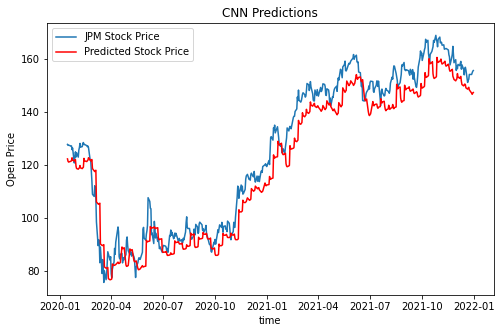

In [16]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_rms.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'].values, predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("CNN Predictions")
plt.legend()
plt.show()
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_cnn1_rms.pdf", bbox_inches='tight', format="pdf")

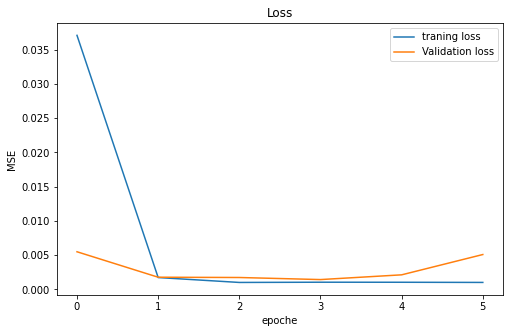

In [18]:
epoche = model2_fit.history['val_loss']
fig = plt.figure(figsize=(8,5))
plt.plot(model2_fit.history['loss'], label="traning loss")
plt.plot(model2_fit.history['val_loss'], label = "Validation loss")
plt.xticks(range(0,len(epoche)))
plt.xlabel("epoche")
plt.ylabel("MSE")
plt.title("Loss")
plt.legend()
plt.show()
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\loss_cnn1_rms.pdf", bbox_inches='tight', format="pdf")

In [19]:
# Modifico il learing rate dell'algoritmo adam a 0.0001
model_5_CNN_3 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu', kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu", kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.Dense(5, activation = "relu", kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02))
    ]
)

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_5_CNN_3.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer, metrics=[keras.metrics.RootMeanSquaredError()])
model_3_fit = model_5_CNN_3.fit(X_train, y_train, batch_size=4, epochs=20, validation_split=0.1, callbacks=[earlyStop])

Epoch 1/20
57/57 [==============================] - 1s 4ms/step - loss: 0.1730 - root_mean_squared_error: 0.4160 - val_loss: 0.6047 - val_root_mean_squared_error: 0.7776
Epoch 2/20
57/57 [==============================] - 0s 2ms/step - loss: 0.1503 - root_mean_squared_error: 0.3877 - val_loss: 0.5031 - val_root_mean_squared_error: 0.7093
Epoch 3/20
57/57 [==============================] - 0s 2ms/step - loss: 0.1068 - root_mean_squared_error: 0.3268 - val_loss: 0.3295 - val_root_mean_squared_error: 0.5740
Epoch 4/20
57/57 [==============================] - 0s 3ms/step - loss: 0.0531 - root_mean_squared_error: 0.2305 - val_loss: 0.1492 - val_root_mean_squared_error: 0.3863
Epoch 5/20
57/57 [==============================] - 0s 2ms/step - loss: 0.0206 - root_mean_squared_error: 0.1436 - val_loss: 0.0541 - val_root_mean_squared_error: 0.2327
Epoch 6/20
57/57 [==============================] - 0s 2ms/step - loss: 0.0126 - root_mean_squared_error: 0.1124 - val_loss: 0.0318 - val_root_mean_sq

Mean Squared Error:	 37.25435498365956
Root Mean Squared Error:	 6.103634571602363


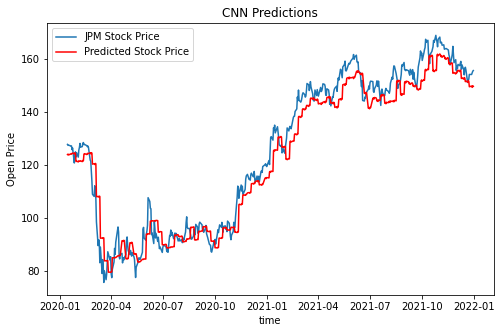

In [21]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_3.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'].values, predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("CNN Predictions")
plt.legend()
plt.show()
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_cnn3.pdf", bbox_inches='tight', format="pdf")

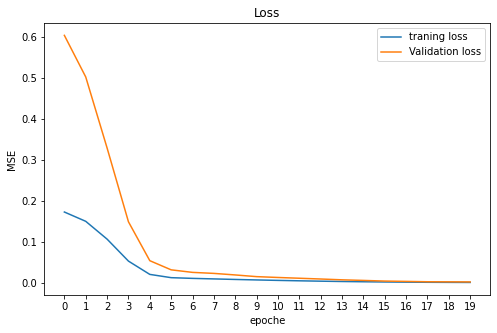

In [23]:
epoche = model_3_fit.history['val_loss']
fig = plt.figure(figsize=(8,5))
plt.plot(model_3_fit.history['loss'], label="traning loss")
plt.plot(model_3_fit.history['val_loss'], label = "Validation loss")
plt.xticks(range(0,len(epoche)))
plt.xlabel("epoche")
plt.ylabel("MSE")
plt.title("Loss")
plt.legend()
plt.show()
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\loss_cnn3.pdf", bbox_inches='tight', format="pdf")

In [35]:
# aggiungo un livello convolutivo in più
model_5_CNN_4 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu', kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.Conv1D(40, kernel_size = 2,activation='relu', kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.Dense(5, activation = "relu", kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02))
    ]
)
model_5_CNN_4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 3, 64)             256       
                                                                 
 conv1d_7 (Conv1D)           (None, 2, 40)             5160      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 40)            0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 40)                0         
                                                                 
 dense_10 (Dense)            (None, 30)                1230      
                                                                 
 dense_11 (Dense)            (None, 5)                 155       
                                                      

In [36]:
model_5_CNN_4.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[keras.metrics.RootMeanSquaredError()])
model_4_fit=model_5_CNN_4.fit(X_train,y_train,epochs=20,batch_size=4, callbacks=[earlyStop], validation_split=0.1)

Epoch 1/20
57/57 [==============================] - 1s 4ms/step - loss: 0.0608 - root_mean_squared_error: 0.2465 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1092
Epoch 2/20
57/57 [==============================] - 0s 2ms/step - loss: 0.0026 - root_mean_squared_error: 0.0512 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0491
Epoch 3/20
57/57 [==============================] - 0s 2ms/step - loss: 6.8779e-04 - root_mean_squared_error: 0.0262 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 4/20
57/57 [==============================] - 0s 2ms/step - loss: 6.2492e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 5/20
57/57 [==============================] - 0s 2ms/step - loss: 6.5979e-04 - root_mean_squared_error: 0.0257 - val_loss: 9.6957e-04 - val_root_mean_squared_error: 0.0311
Epoch 6/20
57/57 [==============================] - 0s 2ms/step - loss: 6.9114e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.001

Mean Squared Error:	 24.53595909272106
Root Mean Squared Error:	 4.95337855334327


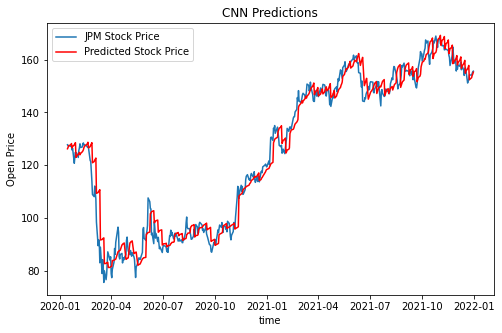

In [37]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_4.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'].values, predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("CNN Predictions")
plt.legend()
plt.show()
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_cnn4.pdf", bbox_inches='tight', format="pdf")

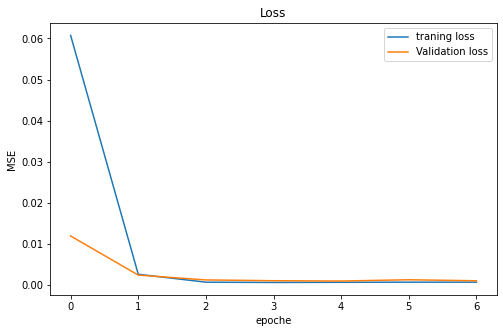

In [39]:
epoche = model_4_fit.history['val_loss']
fig = plt.figure(figsize=(8,5))
plt.plot(model_4_fit.history['loss'], label="traning loss")
plt.plot(model_4_fit.history['val_loss'], label = "Validation loss")
plt.xticks(range(0,len(epoche)))
plt.xlabel("epoche")
plt.ylabel("MSE")
plt.title("Loss")
plt.legend()
plt.show()
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\loss_cnn4.pdf", bbox_inches='tight', format="pdf")

In [40]:
# WALK-FORWARD VALIDATION CON FINESTRA TEMPORALE DI 10 GIORNI
# training set
X_train = []
y_train = []
temp = 5
for i in range(temp, training_set_scaled.shape[0], temp):
  X_train.append(training_set_scaled[i-temp:i+temp, 0])
  y_train.append(training_set_scaled[i:i+temp, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(253, 10)
(253, 10, 1)
(253, 5)


In [41]:
# creazione del test set
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
print(dataset_total.shape)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - temp-temp:].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
inputs = mc.fit_transform(inputs)
print(inputs.shape)

X_test = []
for i in range(5, inputs.shape[0], 5):
  X_test.append(inputs[i-temp:i+temp, 0])
X_test = np.array(X_test)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(1765,)
(505,)
(505, 1)
(100, 10)
(100, 10, 1)


RETE ECODER DECODER CNN-LSTM

In [42]:
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 3, activation = "relu", kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02))(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 3, activation = "relu", kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02))(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm2 = keras.layers.LSTM(200, return_sequences=True, activation="relu", kernel_initializer= keras.initializers.RandomUniform(minval=0, maxval=0.02))(repeat)
decoder = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu", kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)))(decoder_lstm2)
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu", kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)))(decoder)

model_LSTM = keras.Model(encoder_inputs, output)
model_LSTM.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 8, 64)             256       
                                                                 
 conv1d_9 (Conv1D)           (None, 6, 64)             12352     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 192)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 5, 192)           0         
 )                                                           

In [43]:
earlyStop = keras.callbacks.EarlyStopping(patience = 2, mode='min')
model_LSTM.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[keras.metrics.RootMeanSquaredError()])
model_1_lstm=model_LSTM.fit(X_train, y_train, batch_size=16, epochs=20, validation_split=0.1, callbacks=[earlyStop])

Epoch 1/20
15/15 [==============================] - 2s 28ms/step - loss: 0.0528 - root_mean_squared_error: 0.2299 - val_loss: 0.0556 - val_root_mean_squared_error: 0.2357
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 0.0151 - root_mean_squared_error: 0.1227 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1178
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 0.0042 - root_mean_squared_error: 0.0648 - val_loss: 9.9296e-04 - val_root_mean_squared_error: 0.0315
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 7.0852e-04 - root_mean_squared_error: 0.0266 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0616
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 4.5164e-04 - root_mean_squared_error: 0.0213 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0630


Mean Squared Error:	 54.65798343381527
Root Mean Squared Error:	 7.393103775398751


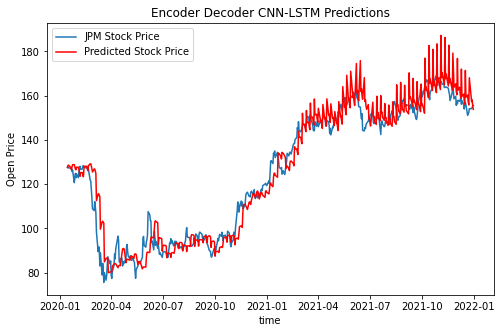

In [45]:
# MSE ed previsioni
predicted_stock_price = model_LSTM.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(predicted_stock_price.shape[0],5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:495])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("Encoder Decoder CNN-LSTM Predictions")
plt.legend()
plt.show()
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_lstm1.pdf", bbox_inches='tight', format="pdf")

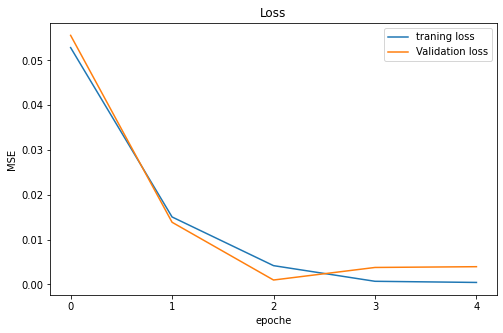

In [47]:
epoche = model_1_lstm.history['val_loss']
fig = plt.figure(figsize=(8,5))
plt.plot(model_1_lstm.history['loss'], label="traning loss")
plt.plot(model_1_lstm.history['val_loss'], label = "Validation loss")
plt.xticks(range(0,len(epoche)))
plt.xlabel("epoche")
plt.ylabel("MSE")
plt.title("Loss")
plt.legend()
plt.show()
fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\loss_lstm1.pdf", bbox_inches='tight', format="pdf")

In [48]:
# utilizzo di RMSprop come algoritmo di ottimizzazione
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 3, activation = "relu", kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02))(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 3, activation = "relu", kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02))(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm2 = keras.layers.LSTM(200, return_sequences=True, activation="relu", kernel_initializer= keras.initializers.RandomUniform(minval=0, maxval=0.02))(repeat)
decoder = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu", kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)))(decoder_lstm2)
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu", kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)))(decoder)

model_LSTM_1 = keras.Model(encoder_inputs, output)

In [49]:
model_LSTM_1.compile(loss=keras.losses.mean_squared_error, optimizer="RMSprop", metrics=[keras.metrics.RootMeanSquaredError()])
model_2_lstm=model_LSTM_1.fit(X_train, y_train, batch_size=16, epochs=20, validation_split=0.1, callbacks=[earlyStop])

Epoch 1/20
15/15 [==============================] - 2s 26ms/step - loss: 0.0448 - root_mean_squared_error: 0.2117 - val_loss: 0.0598 - val_root_mean_squared_error: 0.2445
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 0.0160 - root_mean_squared_error: 0.1266 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0713
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 8.9027e-04 - val_root_mean_squared_error: 0.0298
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 0.0086 - root_mean_squared_error: 0.0926 - val_loss: 0.0399 - val_root_mean_squared_error: 0.1997
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 0.0079 - root_mean_squared_error: 0.0890 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1372


Mean Squared Error:	 122.20879291587498
Root Mean Squared Error:	 11.054808587934708


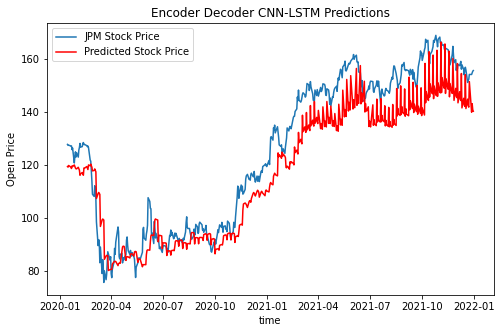

In [77]:
# MSE ed previsioni
predicted_stock_price = model_LSTM_1.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(predicted_stock_price.shape[0],5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:495])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("Encoder Decoder CNN-LSTM Predictions")
plt.legend()
plt.show()
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_lstm_rms.pdf", bbox_inches='tight', format="pdf")

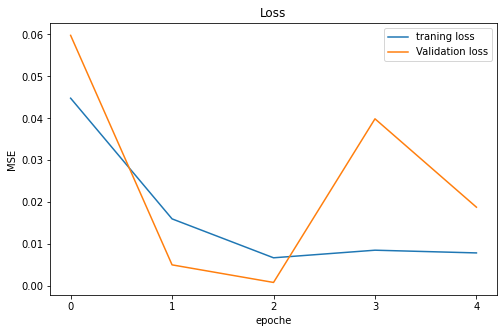

In [78]:
epoche = model_2_lstm.history['val_loss']
fig = plt.figure(figsize=(8,5))
plt.plot(model_2_lstm.history['loss'], label="traning loss")
plt.plot(model_2_lstm.history['val_loss'], label = "Validation loss")
plt.xticks(range(0,len(epoche)))
plt.xlabel("epoche")
plt.ylabel("MSE")
plt.title("Loss")
plt.legend()
plt.show()
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\loss_lstm_rms.pdf", bbox_inches='tight', format="pdf")

In [54]:
# cambio la funzione di attivazione del layer LSTM: utilizzo tanh
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 3, activation = "relu",kernel_initializer= keras.initializers.RandomUniform(minval=0, maxval=0.02))(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 3, activation = "relu",kernel_initializer= keras.initializers.RandomUniform(minval=0, maxval=0.02))(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm = keras.layers.LSTM(200, return_sequences=True, kernel_initializer= keras.initializers.RandomUniform(minval=0, maxval=0.02))(repeat)
decoder = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu", kernel_initializer= keras.initializers.RandomUniform(minval=0, maxval=0.02)))(decoder_lstm)
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu", kernel_initializer= keras.initializers.RandomUniform(minval=0, maxval=0.02)))(decoder)

model_LSTM_2 = keras.Model(encoder_inputs, output)
model_LSTM_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 8, 64)             256       
                                                                 
 conv1d_13 (Conv1D)          (None, 6, 64)             12352     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 192)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 5, 192)           0         
 or)                                                       

In [55]:
model_LSTM_2.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[keras.metrics.RootMeanSquaredError()])
model_3_lstm=model_LSTM_2.fit(X_train, y_train, batch_size=16, epochs=20, validation_split=0.1, callbacks=[earlyStop])

Epoch 1/20
15/15 [==============================] - 2s 41ms/step - loss: 0.0522 - root_mean_squared_error: 0.2284 - val_loss: 0.0574 - val_root_mean_squared_error: 0.2395
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 0.0133 - root_mean_squared_error: 0.1153 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1235
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 4.8969e-04 - root_mean_squared_error: 0.0221 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0490
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 4.2112e-04 - root_mean_squared_error: 0.0205 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382


Mean Squared Error:	 43.023400867568824
Root Mean Squared Error:	 6.559222581035715


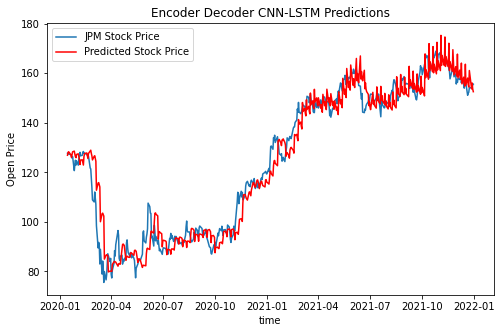

In [57]:
# MSE ed previsioni
predicted_stock_price = model_LSTM_2.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(predicted_stock_price.shape[0],5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:495])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("Encoder Decoder CNN-LSTM Predictions")
plt.legend()
plt.show()
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_lstm_2.pdf", bbox_inches='tight', format="pdf")

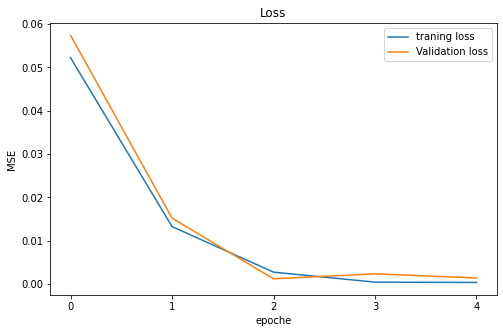

In [60]:
epoche = model_3_lstm.history['val_loss']
fig = plt.figure(figsize=(8,5))
plt.plot(model_3_lstm.history['loss'], label="traning loss")
plt.plot(model_3_lstm.history['val_loss'], label = "Validation loss")
plt.xticks(range(0,len(epoche)))
plt.xlabel("epoche")
plt.ylabel("MSE")
plt.title("Loss")
plt.legend()
plt.show()
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\loss_lstm_2.pdf", bbox_inches='tight', format="pdf")

In [64]:
# aggiungo un livello lstm e denso che lavorano in parallelo sul modulo di decoder
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 3, activation = "relu",kernel_initializer= keras.initializers.RandomUniform(minval=0, maxval=0.02))(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 2, activation = "relu",kernel_initializer= keras.initializers.RandomUniform(minval=0, maxval=0.02))(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm = keras.layers.LSTM(200, return_sequences=True, kernel_initializer= keras.initializers.RandomUniform(minval=0, maxval=0.02))(repeat)
decoder1 = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu", kernel_initializer= keras.initializers.RandomUniform(minval=0, maxval=0.02)))(decoder_lstm)
decoder_lstm2 = keras.layers.LSTM(200, return_sequences=True,kernel_initializer= keras.initializers.RandomUniform(minval=0, maxval=0.02))(repeat)
decoder2 =keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu",kernel_initializer= keras.initializers.RandomUniform(minval=0, maxval=0.02)))(decoder_lstm2)
conc = keras.layers.concatenate([decoder1,decoder2])
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu",kernel_initializer= keras.initializers.RandomUniform(minval=0, maxval=0.02)))(conc)

model_LSTM_3 = keras.Model(encoder_inputs, output)
model_LSTM_3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 10, 1)]      0           []                               
                                                                                                  
 conv1d_16 (Conv1D)             (None, 8, 64)        256         ['input_11[0][0]']               
                                                                                                  
 conv1d_17 (Conv1D)             (None, 7, 64)        8256        ['conv1d_16[0][0]']              
                                                                                                  
 max_pooling1d_10 (MaxPooling1D  (None, 3, 64)       0           ['conv1d_17[0][0]']              
 )                                                                                          

In [65]:
model_LSTM_3.compile(loss=keras.losses.mean_squared_error, optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])
model_4_fit=model_LSTM_3.fit(X_train, y_train, batch_size=16, epochs=20, validation_split=0.1, callbacks=[earlyStop])

Epoch 1/20
15/15 [==============================] - 4s 63ms/step - loss: 0.0394 - root_mean_squared_error: 0.1984 - val_loss: 0.0446 - val_root_mean_squared_error: 0.2112
Epoch 2/20
15/15 [==============================] - 0s 16ms/step - loss: 0.0116 - root_mean_squared_error: 0.1076 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0958
Epoch 3/20
15/15 [==============================] - 0s 15ms/step - loss: 0.0024 - root_mean_squared_error: 0.0493 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 4/20
15/15 [==============================] - 0s 16ms/step - loss: 7.1810e-04 - root_mean_squared_error: 0.0268 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0468
Epoch 5/20
15/15 [==============================] - 0s 15ms/step - loss: 5.1029e-04 - root_mean_squared_error: 0.0226 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 6/20
15/15 [==============================] - 0s 15ms/step - loss: 3.5714e-04 - root_mean_squared_error: 0.0189 - val_loss: 8.3869e

Mean Squared Error:	 47.5595905912064
Root Mean Squared Error:	 6.896346176868327


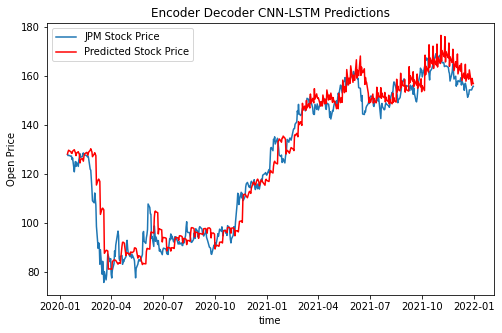

In [84]:
predicted_stock_price = model_LSTM_3.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(predicted_stock_price.shape[0],5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:495])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("Encoder Decoder CNN-LSTM Predictions")
plt.legend()
plt.show()
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_lstm_3.pdf", bbox_inches='tight', format="pdf")

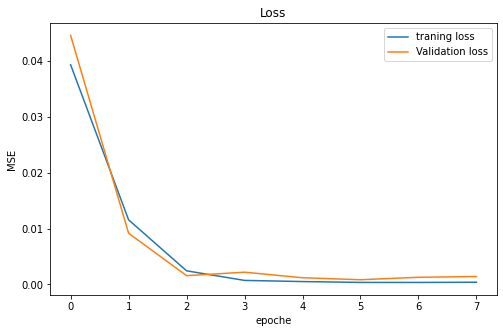

In [85]:
epoche = model_4_fit.history['val_loss']
fig = plt.figure(figsize=(8,5))
plt.plot(model_4_fit.history['loss'], label="traning loss")
plt.plot(model_4_fit.history['val_loss'], label = "Validation loss")
plt.xticks(range(0,len(epoche)))
plt.xlabel("epoche")
plt.ylabel("MSE")
plt.title("Loss")
plt.legend()
plt.show()
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\loss_lstm_3.pdf", bbox_inches='tight', format="pdf")

In [70]:
# abbasso il learning rate dell'algoritmo adam a 0.0001
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 3, activation = "relu",kernel_initializer= keras.initializers.RandomUniform(minval=0, maxval=0.02))(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 3, activation = "relu",kernel_initializer= keras.initializers.RandomUniform(minval=0, maxval=0.02))(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm = keras.layers.LSTM(200, return_sequences=True, kernel_initializer= keras.initializers.RandomUniform(minval=0, maxval=0.02))(repeat)
decoder = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu", kernel_initializer= keras.initializers.RandomUniform(minval=0, maxval=0.02)))(decoder_lstm)
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu", kernel_initializer= keras.initializers.RandomUniform(minval=0, maxval=0.02)))(decoder)

model_LSTM_4 = keras.Model(encoder_inputs, output)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_LSTM_4.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer, metrics=[keras.metrics.RootMeanSquaredError()])
model_5_fit=model_LSTM_4.fit(X_train, y_train, batch_size=16, epochs=20, validation_split=0.1, callbacks=[earlyStop])

Epoch 1/20
15/15 [==============================] - 3s 41ms/step - loss: 0.1110 - root_mean_squared_error: 0.3332 - val_loss: 0.2800 - val_root_mean_squared_error: 0.5291
Epoch 2/20
15/15 [==============================] - 0s 13ms/step - loss: 0.0505 - root_mean_squared_error: 0.2248 - val_loss: 0.1011 - val_root_mean_squared_error: 0.3180
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 0.0304 - root_mean_squared_error: 0.1743 - val_loss: 0.0893 - val_root_mean_squared_error: 0.2989
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 0.0251 - root_mean_squared_error: 0.1584 - val_loss: 0.0816 - val_root_mean_squared_error: 0.2857
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 0.0215 - root_mean_squared_error: 0.1465 - val_loss: 0.0645 - val_root_mean_squared_error: 0.2539
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 0.0182 - root_mean_squared_error: 0.1349 - val_loss: 0.0544 - val_root_m

Mean Squared Error:	 42.66227913147708
Root Mean Squared Error:	 6.5316367880858985


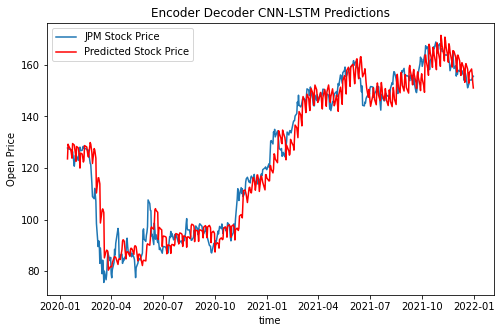

In [88]:
predicted_stock_price = model_LSTM_4.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(predicted_stock_price.shape[0],5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:495])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("Encoder Decoder CNN-LSTM Predictions")
plt.legend()
plt.show()
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_lstm_4.pdf", bbox_inches='tight', format="pdf")

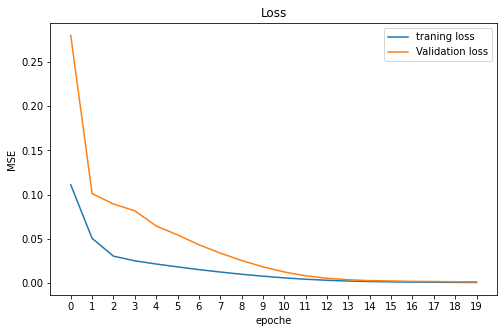

In [89]:
epoche = model_5_fit.history['val_loss']
fig = plt.figure(figsize=(8,5))
plt.plot(model_5_fit.history['loss'], label="traning loss")
plt.plot(model_5_fit.history['val_loss'], label = "Validation loss")
plt.xticks(range(0,len(epoche)))
plt.xlabel("epoche")
plt.ylabel("MSE")
plt.title("Loss")
plt.legend()
plt.show()
#fig.savefig("D:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\loss_lstm_4.pdf", bbox_inches='tight', format="pdf")